In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

In [ ]:
import pandas as pd

def trace_to_df(filename : str) -> pd.DataFrame:
    with open(filename, 'r') as file:
        datatypes = {'s', 'v', 'p', 'f', 'b', 'h'}
        default_values = {'time': 0, 'controller_index' : 0, 'changed' : 0, 'isActive' : 0 , "lastChanged" : 0, 'vtype' : 0,
                         'o.x' : 0.0, 'o.y' : 0.0, 'o.z' : 0.0, 'o.w' : 0.0,
                         'p.x' : 0.0, 'p.y' : 0.0, 'p.z' : 0.0,
                         'u' : 0.0, 'r' : 0.0, 'd' : 0.0, 'l' : 0.0,
                         'type' : '-', 'input' : 'default_input', 'l.basespace' : 'default_basespace'}

        trace_dict = {key: [] for key in datatypes}

        # Get individual lines into the correct datatype buckets
        for line in file:
            for char in line:
                if not char.isdigit() and not char.isspace():
                    trace_dict[char].append(line.strip().split(' '))
                    break

        # handle data cleanup and type assignments for space
        space_names = ['time', 'type', 'input', 'errorcase', 'o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z', 'l.basespace']
        space_dataframe = pd.DataFrame(trace_dict['s'], columns=space_names)
        space_dataframe.drop('errorcase', axis=1, inplace=True)

        space_dataframe[['input','type', 'l.basespace']] = space_dataframe[['input','type', 'l.basespace']].astype(str)
        space_dataframe[['o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z']] = space_dataframe[['o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z']].astype(float)

        space_dataframe['time'] = space_dataframe[['time']].apply(pd.to_numeric)

        # handle data cleanup and type assignments for view
        view_names = ['time', 'type', 'input', 'errorcase', 'o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z', 'u', 'r', 'd', 'l', 'vtype', 'controller_index']
        view_dataframe = pd.DataFrame(trace_dict['v'], columns=view_names)
        view_dataframe.drop('errorcase', axis=1, inplace=True)

        view_dataframe[['input','type']] = view_dataframe[['input','type']].astype(str)
        view_dataframe[['o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z']] = view_dataframe[['o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z']].astype(float)
        view_dataframe[['u', 'r', 'd', 'l']] = view_dataframe[['u', 'r', 'd', 'l']].astype(float)

        view_dataframe[['time', 'vtype', 'controller_index']] = view_dataframe[['time', 'vtype', 'controller_index']].apply(pd.to_numeric)

        # handle data cleanup and type assignments for position
        position_names = ['time', 'type', 'input', 'errorcase', 'changed','isActive','lastChanged','p.x', 'p.y']
        position_dataframe = pd.DataFrame(trace_dict['p'], columns=position_names)
        position_dataframe.drop('errorcase', axis=1, inplace=True)

        position_dataframe[['input','type']] = position_dataframe[['input','type']].astype(str)
        position_dataframe[['changed','isActive','lastChanged']] = position_dataframe[['changed','isActive','lastChanged']].apply(pd.to_numeric)
        position_dataframe[['p.x', 'p.y']] = position_dataframe[['p.x', 'p.y']].astype(float)

        position_dataframe[['time']] = position_dataframe[['time']].apply(pd.to_numeric)

        # handle data cleanup and type assignments for float
        float_names = ['time', 'type', 'input', 'errorcase', 'changed','isActive','lastChanged','p.x']
        float_dataframe = pd.DataFrame(trace_dict['f'], columns=float_names)
        float_dataframe.drop('errorcase', axis=1, inplace=True)

        float_dataframe[['input','type']] = float_dataframe[['input','type']].astype(str)
        float_dataframe[['time', 'changed','isActive','lastChanged']] = float_dataframe[['time', 'changed','isActive','lastChanged']].apply(pd.to_numeric)
        float_dataframe[['p.x']] = float_dataframe[['p.x']].astype(float)

        # handle data cleanup and type assignments for boolean
        boolean_names = ['time', 'type', 'input', 'errorcase', 'changed','isActive','lastChanged','p.x']
        boolean_dataframe = pd.DataFrame(trace_dict['b'], columns=boolean_names)
        boolean_dataframe.drop('errorcase', axis=1, inplace=True)

        boolean_dataframe[['input','type']] = boolean_dataframe[['input','type']].astype(str)
        boolean_dataframe[['time', 'changed','isActive','lastChanged']] = boolean_dataframe[['time', 'changed','isActive','lastChanged']].apply(pd.to_numeric)
        boolean_dataframe[['p.x']] = boolean_dataframe[['p.x']].astype(float)


        # handle data cleanup and type assignments for haptic
        haptic_names = ['time', 'type', 'input', 'errorcase', 'p.x']
        haptic_dataframe = pd.DataFrame(trace_dict['h'], columns=haptic_names)
        haptic_dataframe.drop('errorcase', axis=1, inplace=True)

        haptic_dataframe[['input','type']] = haptic_dataframe[['input','type']].astype(str)
        haptic_dataframe[['time']] = haptic_dataframe[['time']].apply(pd.to_numeric)
        haptic_dataframe[['p.x']] = haptic_dataframe[['p.x']].astype(float)

        # Concat the data into one dataframe
        trace_df = pd.concat([haptic_dataframe, view_dataframe, space_dataframe, boolean_dataframe, float_dataframe, position_dataframe], ignore_index=True)

        # sort on time and fill na with default value for that column
        trace_df.sort_values(by=['time'], inplace=True)
        trace_df.reset_index(drop=True, inplace=True)

        trace_df.fillna(default_values, inplace=True)
        trace_df[['changed','isActive','lastChanged']] = trace_df[['changed','isActive','lastChanged']].astype("int64")
        trace_df[['vtype', 'controller_index']] = trace_df[['vtype', 'controller_index']].astype("int64")

        return trace_df

# now do something with the df.
trace_df = trace_to_df('/content/drive/MyDrive/distributed system/traces-new.txt')

In [ ]:
data_df = trace_df[trace_df['input'].isin(['/user/hand/left/input/aim/pose','/user/hand/left/input/grip/pose'])]

In [ ]:
col_size_1 = len(data_df['type'].unique())
col_size_2 = len(data_df['input'].unique())

In [ ]:
data_df = pd.get_dummies(data_df, columns=["type", "input", "l.basespace"])

In [ ]:
column_len = len(data_df.columns)

In [ ]:

# Assuming data_df is your DataFrame and contains both numerical and one-hot encoded categorical columns
numerical_cols = data_df.select_dtypes(include=['int64','float64']).columns
categorical_cols = data_df.select_dtypes(include=['uint8']).columns  # one-hot columns are often 'uint8'

numerical_data = data_df[numerical_cols]
categorical_data = data_df[categorical_cols]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Convert the scaled data back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols)

In [ ]:
# Combine scaled numerical data and categorical data
final_df = pd.concat([scaled_numerical_df.fillna(scaled_numerical_df.mean()), categorical_data], axis=1)
final_df = final_df.fillna(0)

In [ ]:
# Step 4: Create Sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

sequence_length = 250  # This is a hyperparameter you can tune
sequences = create_sequences(final_df, sequence_length)

In [ ]:
from sklearn.model_selection import train_test_split

X = sequences[:-1]
y = sequences[1:, 0, :]


# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X_train_main = X_train[:,:,0:17]
X_train_condition_1 = X_train[:,:,17:17+col_size_1]
X_train_condition_2 = X_train[:,:,17+col_size_1:17+col_size_1 + col_size_2]
X_train_condition_3 = X_train[:,:,17+col_size_1 + col_size_2:]

In [ ]:
X_test_main = X_test[:, :, 0:17]
X_test_condition_1 = X_test[:, :, 17:17+col_size_1]
X_test_condition_2 = X_test[:, :, 17+col_size_1:17+col_size_1 + col_size_2]
X_test_condition_3 = X_test[:, :, 17+col_size_1 + col_size_2: ]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Concatenate, RepeatVector
from tensorflow.keras.layers import Bidirectional


# Main input
main_input = Input(shape=(X_train_main.shape[1], X_train_main.shape[2]), name='main_input')

# Conditional inputs - Assuming these are time-dependent
cond_input1 = Input(shape=(X_train_condition_1.shape[1], X_train_condition_1.shape[2]), name='cond_input1')
cond_input2 = Input(shape=(X_train_condition_2.shape[1], X_train_condition_2.shape[2]), name='cond_input2')
cond_input3 = Input(shape=(X_train_condition_3.shape[1], X_train_condition_3.shape[2]), name='cond_input3')

# Concatenate the main input with the conditional inputs
concatenated_input = Concatenate(axis=-1)([main_input, cond_input1, cond_input2, cond_input3])

# LSTM layers
lstm_out = Bidirectional(LSTM(units=column_len, return_sequences=True))(concatenated_input)
lstm_out = Dropout(0.1)(lstm_out)
lstm_out = Bidirectional(LSTM(units=column_len))(lstm_out)
lstm_out = Dropout(0.1)(lstm_out)

# Output layer
output = Dense(units=column_len)(lstm_out)  # Adjust the number of units as per your requirements

# Build the model
model = Model(inputs=[main_input, cond_input1, cond_input2, cond_input3], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train_main, X_train_condition_1, X_train_condition_2, X_train_condition_3], y_train, epochs=50, batch_size=2048, validation_split=0.1)


ValueError: Input 0 of layer "bidirectional_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 42)

In [ ]:
def add_noise_to_int_fields(seed_sequence, noise_level=0.01):
    # Create an array to hold the noise
    noise = np.zeros(seed_sequence.shape, seed_sequence.dtype)

    # Iterate over each field in the seed_sequence
    for i in range(len(seed_sequence)):
        # Check if the current field is an integer
        if np.issubdtype(seed_sequence[i].dtype, np.integer):
            # Add noise only to integer fields
            noise[i] = np.random.normal(0, noise_level, seed_sequence[i].shape)

    return seed_sequence + noise

def generate_sequence(model, seed_sequence, seed_cond1, seed_cond2,seed_cond3, num_steps, input_features, output_features):
    generated_sequence = np.zeros((num_steps, output_features))

    # Create a buffer for the current sequence with the correct number of input features
    current_sequence = np.zeros((sequence_length, input_features))

    # Initialize the buffer with the seed sequence
    seed_len = min(sequence_length, seed_sequence.shape[0])
    current_sequence[-seed_len:, :seed_sequence.shape[1]] = seed_sequence[-seed_len:]

    # Reshape conditional inputs
    cond1 = seed_cond1.reshape(1, -1, seed_cond1.shape[1])
    cond2 = seed_cond2.reshape(1, -1, seed_cond2.shape[1])
    cond3 = seed_cond3.reshape(1, -1, seed_cond3.shape[1])

    for i in range(num_steps):
        # Prepare the current inputs for the model
        current_input = current_sequence.reshape(1, sequence_length, input_features)
        current_inputs = [current_input, cond1, cond2, cond3]

        # Get the last time step prediction from the model
        next_step = model.predict(current_inputs)

        # Update the generated_sequence with the predicted step
        generated_sequence[i] = next_step

        # Update the current_sequence with the new step
        current_sequence = np.roll(current_sequence, -1, axis=0)
        # Adjust the next_step to match the input features if necessary
        current_sequence[-1, :seed_sequence.shape[1]] = next_step[:, :seed_sequence.shape[1]]

    return generated_sequence


# Select a seed sequence from your data and the corresponding conditional inputs
seed_sequence = X_train_main[0]  # Example: taking the first sequence from the training set
seed_cond1 = X_train_condition_1[0]  # Static conditional input 1 for the seed
seed_cond2 = X_train_condition_2[0]  # Static conditional input 2 for the seed
seed_cond3 = X_train_condition_3[0]

# Generate a new sequence
num_steps = 5000  # Number of steps to generate
# noisy_seed_sequence = add_noise_to_int_fields(seed_sequence)
input_features = 17
output_features = column_len
new_sequence = generate_sequence(model, seed_sequence, seed_cond1, seed_cond2,seed_cond3, num_steps, input_features, output_features)


In [ ]:
numerical_data = scaler.inverse_transform(new_sequence[:,:17])
# Create a DataFrame from the numerical data
numerical_df = pd.DataFrame(numerical_data, columns=numerical_cols)

In [ ]:
categorical_df = pd.DataFrame(new_sequence[:,17:], columns=categorical_cols)

In [ ]:
import pandas as pd

def convert_dummies_to_categorical(df, prefix):
    # Filter columns that start with the prefix
    relevant_columns = [col for col in df.columns if col.startswith(prefix)]

    # Extract the relevant columns for processing
    relevant_data = df[relevant_columns]

    # Find the column with the highest value for each row
    # and extract the part of the column name after the prefix
    category_col_name = f'{prefix.strip("_")}'
    df[category_col_name] = relevant_data.idxmax(axis=1).apply(lambda x: x[len(prefix):] if relevant_data.loc[df.index == relevant_data.index[0], x].max() != 0 else 'None')

    # Drop the original dummy columns
    df = df.drop(columns=relevant_columns)

    return df


# Convert for left hand input columns
categorical_df = convert_dummies_to_categorical(categorical_df, 'input_')

# # Convert for right hand input columns
categorical_df = convert_dummies_to_categorical(categorical_df, 'type_')

categorical_df = convert_dummies_to_categorical(categorical_df, 'l.basespace_')


In [ ]:
final_df = pd.concat([categorical_df, numerical_df], axis=1)

In [ ]:
import pandas as pd

def get_decimal_places(number):
    # Convert to string
    number_str = str(number)
    # Find the decimal point
    if '.' in number_str:
        return len(number_str.split('.')[1])
    else:
        return 0

def standardize_dataframes(df1: pd.DataFrame, df2: pd.DataFrame):
    # Ensure the dataframes have the same columns
    assert set(df1.columns) == set(df2.columns), "DataFrames do not have the same columns"

    for col in df1.columns:
        # Match data types
        df2[col] = df2[col].astype(df1[col].dtype)

        # Standardize decimal places for floating-point numbers
        if pd.api.types.is_float_dtype(df1[col].dtype):
            # Determine the max number of decimal places in df1 column
            max_decimals = df1[col].apply(get_decimal_places).max()
            df1[col] = df1[col].round(max_decimals)
            df2[col] = df2[col].round(max_decimals)

    return df1, df2

# Example usage
df1, df2 = standardize_dataframes(final_df, trace_df)


In [ ]:
import pandas as pd

def format_value(val):
    """Converts floats with no decimal part to integers."""
    if isinstance(val, float) and val.is_integer():
        return int(val)
    return val

def df_to_trace(filename: str, trace_df: pd.DataFrame):
    with open(filename, 'w') as file:
        for i in trace_df.index:
            columns = []

            if trace_df['type'][i] == 's':
                columns = ['time', 'type', 'input', 'o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z', 'l.basespace']
            elif trace_df['type'][i] == 'v':
                columns = ['time', 'type', 'input', 'o.x', 'o.y', 'o.z', 'o.w', 'p.x', 'p.y', 'p.z', 'u', 'r', 'd', 'l', 'vtype', 'controller_index']
            elif trace_df['type'][i] == 'f':
                columns = ['time', 'type', 'input', 'changed', 'isActive', 'lastChanged', 'p.x']
            elif trace_df['type'][i] == 'p':
                columns = ['time', 'type', 'input', 'changed', 'isActive', 'lastChanged', 'p.x', 'p.y']
            elif trace_df['type'][i] == 'b':
                columns = ['time', 'type', 'input', 'changed', 'isActive', 'lastChanged', 'p.x']
            elif trace_df['type'][i] == 'h':
                columns = ['time', 'type', 'input', 'p.x']

            line = ""
            for column_name in columns:
                val = format_value(trace_df[column_name][i])
                line += str(val) + " "

            file.write(line.strip() + "\n")  # Using strip() to remove the trailing space

# Example usage
# df_to_trace("output_trace.txt", trace_df)


In [ ]:
trace_df = (trace_df[trace_df['input'] == '/user/hand/left/input/grip/pose']).reset_index()



In [ ]:
merged_df = trace_df.merge(df_generated, left_index=True, right_index=True, suffixes=('_org','_gen'))

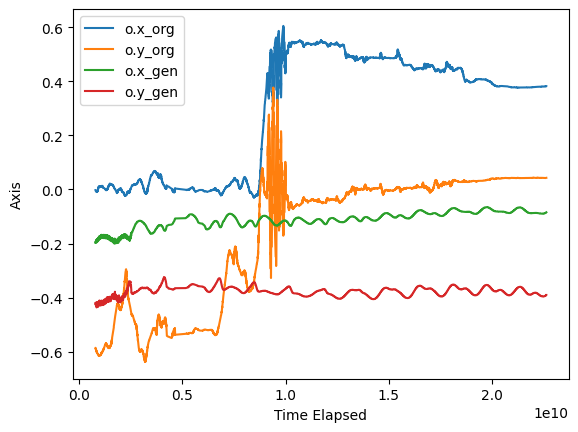

In [ ]:
merged_df.plot(x='time_org', y=['o.x_org', 'o.y_org', 'o.x_gen', 'o.y_gen'], legend=['X', 'Y', 'Generated X', 'Generated Y'])
plt.xlabel('Time Elapsed')  # Label for the x-axis
plt.ylabel('Axis')
plt.savefig('./plot.pdf')


In [ ]:
final_df = pd.DataFrame()

idx = 0

for _, row in tqdm(trace_df.iterrows(), total=trace_df.shape[0]):
  generated_row = df_generated.loc[idx]
  if row['l.basespace'] == generated_row['l.basespace']:
    if row['input'] == generated_row['input']:
      if row['type'] == generated_row['type']:
        generated_row['time'] = row['time']
        generated_row['lastChanged'] = row['lastChanged']
        final_df = final_df.append(generated_row, ignore_index=True)
        idx += 1
        continue
  final_df = final_df.append(row, ignore_index=True)



  0%|          | 0/9632 [00:00<?, ?it/s]

In [ ]:
final_df[final_df['input'] == '/user/hand/left/input/grip/pose']

,time,type,input,p.x,o.x,o.y,o.z,o.w,p.y,p.z,u,r,d,l,vtype,controller_index,l.basespace,changed,isActive,lastChanged
60,796819129,s,/user/hand/left/input/grip/pose,-0.352193,-0.280683,-0.418742,-0.352707,0.759519,0.783775,-0.131815,-0.007385,-0.014372,-0.002263,0.002164,0.004836,-0.007602,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004525,0.001817,0
65,796826515,s,/user/hand/left/input/grip/pose,-0.351731,-0.280105,-0.416280,-0.351707,0.760707,0.783699,-0.131181,-0.006976,-0.014114,-0.002312,0.001754,0.005089,-0.007408,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004415,0.001804,0
71,810708017,s,/user/hand/left/input/grip/pose,-0.351571,-0.279574,-0.415951,-0.352032,0.761325,0.783542,-0.130958,-0.006503,-0.013640,-0.002316,0.001431,0.005155,-0.007330,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004136,0.001979,0
74,824594129,s,/user/hand/left/input/grip/pose,-0.351873,-0.279314,-0.417921,-0.353024,0.760870,0.783555,-0.131484,-0.005395,-0.013356,-0.002502,0.001377,0.004166,-0.007303,XR_REFERENCE_SPACE_TYPE_STAGE,-0.003967,0.002005,0
85,838483017,s,/user/hand/left/input/grip/pose,-0.352306,-0.281604,-0.418587,-0.354033,0.760680,0.782715,-0.131708,-0.005435,-0.012912,-0.002327,0.000913,0.003963,-0.006802,XR_REFERENCE_SPACE_TYPE_STAGE,-0.003923,0.002033,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61908,68775311529,s,/user/hand/left/input/grip/pose,-0.347296,-0.260008,-0.364589,-0.319246,0.781567,0.793279,-0.120456,-0.003649,-0.009305,-0.002294,-0.001787,0.007311,-0.005172,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004393,0.001598,0
61916,68789173328,s,/user/hand/left/input/grip/pose,-0.347296,-0.260008,-0.364589,-0.319246,0.781567,0.793279,-0.120456,-0.003649,-0.009305,-0.002294,-0.001787,0.007311,-0.005172,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004393,0.001598,0
61921,68789200417,s,/user/hand/left/input/grip/pose,-0.347296,-0.260008,-0.364589,-0.319246,0.781567,0.793279,-0.120456,-0.003649,-0.009305,-0.002294,-0.001787,0.007311,-0.005172,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004393,0.001598,0
61928,68803047126,s,/user/hand/left/input/grip/pose,-0.347296,-0.260008,-0.364589,-0.319246,0.781567,0.793279,-0.120456,-0.003649,-0.009305,-0.002294,-0.001787,0.007311,-0.005172,XR_REFERENCE_SPACE_TYPE_STAGE,-0.004393,0.001598,0
